In [1]:
import sys; sys.path.append('/sj0243/')

In [2]:
from python_for_nustar.pyxspec_lib.nustar_xspec import scan_containers_ph_res, query_par, ph_res_param, Model, Fit, Plot, xspec, AllData, AllModels
from python_for_nustar.nu_core import set_mpl, plt
import astropy.io.fits as fits
from python_for_nustar.nu_class import NustarObservation, glob
from python_for_nustar.pipeline.sj0243_init import Nu_path, ObsList_bright, plot_path, ObsAlias
from cycler import cycler
import scipy

set_mpl('pastel')

xspec.AllModels.lmod('relxill', '/sj0243/python_for_nustar/relxill_model/')


In [3]:
set_mpl('pastel')
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'r', 'g', 'g', 'b','b', 'violet', 'violet', 'brown', 'brown', 'pink', 'pink'])))

In [12]:
def plot_pulse_profile(ObsID, ax_pp):

    ff_zero = fits.open(f'/sj0243/results/out{ObsID}/products/phase_resolved/phase_resolved_bin1AB_sr.lc_bary_orb_corr_nphase_128.efold')
    phase_zero = ff_zero[1].data["PHASE"]
    rate_zero = ff_zero[1].data["RATE1"]
    idx = np.where(~np.isnan(rate_zero))[0][0]
    ph_shift = phase_zero[idx] * (-1)



    f   = fits.open(f'/sj0243/results/out{ObsID}/products/spe_and_lc/spe_and_lcAB_sr.lc_bary_orb_corr_nphase_128.efold')
    ph, rate, err = f[1].data['PHASE']+ ph_shift,  f[1].data['RATE1'],  f[1].data['ERROR1']
    roll_idx  = 0#roll_idx = -np.argmin(rate)
    rate = np.roll(rate, roll_idx)
    err = np.roll(err, roll_idx)

    rate = np.tile(rate, 2)
    err = np.tile(err, 2)
    ph = np.hstack((ph, ph+1))

    ax_pp.step(ph, rate, where='mid', color = 'k')
    return ph, rate

def plot_relf_spe(
    ObsID,
    bin_numbers,
    min_sig = 75,
):
    ms, alpha, lw = 4, 0.7, 3


    fig = plt.figure(figsize=(8, 12))
    plotwidth = 4
    rows = len(bin_numbers)+plotwidth
    cols = 1
    ax = plt.subplot2grid((rows, cols), (0, 0), rowspan=plotwidth, colspan=1)
    ax_delchi = [plt.subplot2grid((rows, cols), (i, 0),
                                rowspan=1, colspan=1, sharex=ax) for i in range(plotwidth, rows)]
    plt.subplots_adjust(hspace=0)


    ax_pp = ax.inset_axes([0.3, 0.9, 0.4, 0.2])
    plot_pulse_profile(ObsID, ax_pp)
    ax_pp.tick_params(axis='both',which='both',labelbottom=False,bottom=False,top = False,left=False)
    ax_pp.set_yticks([]) 
    

    for i, bin_number in enumerate(bin_numbers):
        os.chdir(f"/sj0243/results/out{ObsID}/products/phase_resolved")
        xspec.AllData.clear()
        xspec.AllModels.clear()
        model = 'relxilllp'
        xspec.Xset.restore(f'/sj0243/results/out{ObsID}/products/phase_resolved/xspec/{model}/xcm/{ObsID}_bin{bin_number}_shift0_{model}.xcm')

        mo_loaded = xspec.AllModels(1)
        refl_fract = mo_loaded.relxilllp.refl_frac.values[0]
        refl_fract = f"{refl_fract:.2f}"
        print(f"Obs {ObsID}; bin {bin_number}; refl_factor = {refl_fract}")

        label = f'Bin {bin_number}; $f_{{refl}}$ = {refl_fract}'


        for gr, m, l in zip([1,2], ['o', 's'], [label, '_'+ label]):

            Plot.device = "/null"
            Plot.setRebin(min_sig, min_sig)
            Plot("eeufs")
            Plot.xAxis = "keV"
            en = np.array(Plot.x(gr))
            data = np.array(Plot.y(gr))
            en_err = np.array(Plot.xErr(gr))
            data_err = np.array(Plot.yErr(gr))

            ax.loglog(en, data, marker = m, lw = 0, alpha = alpha, ms = ms)#, zorder = 10)   
            color =  ax.get_lines()[-1].get_color()         
            ax.errorbar(en, data, data_err, en_err,
                            fmt='none', ecolor=color, alpha=alpha*0.7, label=l)#, zorder = 9)

            Plot("del")
            Plot.xAxis = "keV"
            en = np.array(Plot.x(gr))
            delchi = np.array(Plot.y(gr))
            en_err = np.array(Plot.xErr(gr))
            delchi_err = np.array(Plot.yErr(gr))

            ax_delchi[i].semilogx(en, delchi, marker = m, lw = 0, alpha = alpha, ms = ms, color = color)
            ax_delchi[i].errorbar(en, delchi, delchi_err, en_err,
                            fmt='none', ecolor=color, alpha=alpha*0.7, label=l)#, zorder = 9)
            ax_delchi[i].set_ylabel("$\chi$")


            if gr==1:
                b = bin_number
                ax_pp.axvspan((b-1)/10, b/10, color = color, alpha = 0.4)


        xspec.Xset.restore(f'/sj0243/results/out{ObsID}/products/phase_resolved/xspec/{model}/xcm/{ObsID}_bin{bin_number}_shift0_{model}.xcm_model')

        mo_loaded = xspec.AllModels(1)
        #AllData.dummyrsp(4, 79., 250)
        refl_fract = mo_loaded.relxilllp.refl_frac.values[0]
        refl_fract = f"{refl_fract:.2f}"
        print(f"Obs {ObsID}; bin {bin_number}; refl_factor = {refl_fract}")
        #mo_loaded.relxilllp.refl_frac = "-"+str(refl_fract)
        #mo_loaded.bbodyrad.norm = '0 -1'

        Plot("eeufs")
        Plot.xAxis = "keV"
        en = np.array(Plot.x())
        data = np.array(Plot.model())

        ax.loglog(en, data, lw = lw, alpha = alpha, ls = '-', color = color)   


        xspec.Xset.restore(f'/sj0243/results/out{ObsID}/products/phase_resolved/xspec/{model}/xcm/{ObsID}_bin{bin_number}_shift0_{model}.xcm_model')
        mo_loaded = xspec.AllModels(1)
        refl_fract = mo_loaded.relxilllp.refl_frac.values[0]
        mo_loaded.relxilllp.refl_frac = "-"+str(refl_fract)
        mo_loaded.bbodyrad.norm = '0 -1'

        Plot("eeufs")
        Plot.xAxis = "keV"
        en = np.array(Plot.x())
        data = np.array(Plot.model())

        ax.loglog(en, data, lw = lw+0.5, alpha = 0.9, ls = ':', color = color, zorder = 10)   
        AllModels.calcFlux(f"4. 10.")
        #fl = AllModels(1).flux
        #print(fl)
        #fl = fl[0]
        #print(f'reflected flux = {fl}')

        xspec.Xset.restore(f'/sj0243/results/out{ObsID}/products/phase_resolved/xspec/{model}/xcm/{ObsID}_bin{bin_number}_shift0_{model}.xcm_model')
        mo_loaded = xspec.AllModels(1)
        refl_fract = mo_loaded.relxilllp.refl_frac.values[0]
        mo_loaded.relxilllp.refl_frac = '0 -1'
        mo_loaded.bbodyrad.norm = '0 -1'

        Plot("eeufs")
        Plot.xAxis = "keV"
        en = np.array(Plot.x())
        data = np.array(Plot.model())

        ax.loglog(en, data, lw = lw, alpha = alpha, ls = '--', color = color)   


        xspec.Xset.restore(f'/sj0243/results/out{ObsID}/products/phase_resolved/xspec/{model}/xcm/{ObsID}_bin{bin_number}_shift0_{model}.xcm_model')
        mo_loaded = xspec.AllModels(1)
        refl_fract = mo_loaded.relxilllp.refl_frac.values[0]
        mo_loaded.relxilllp.norm = '0'

        Plot("eeufs")
        Plot.xAxis = "keV"
        en = np.array(Plot.x())
        data = np.array(Plot.model())

        ax.loglog(en, data, lw = lw, alpha = alpha/2, ls = '-.', color = 'k')   




        ax.set_xscale("log")
        ax_delchi[-1].set_xlabel("Energy (keV)")


        ax.set_ylabel('$E^2F_E, keV^2 (phot\, cm^{-2} s^{-1} keV^{-1})$', fontsize = 14)
        #l = ax.legend(loc="upper right", title = ObsAlias[ObsID], fontsize = 14,  title_fontsize = 14)
        l = ax.legend(bbox_to_anchor=(0.7, 0.8), loc = 'lower left', title = ObsAlias[ObsID], fontsize = 14,  title_fontsize = 14, framealpha=0.9)
        #l.set_zorder(-1)
        for lh in l.legendHandles:
            lh.set_alpha(1)
        ax.set_xticks([4, 6, 7, 10, 20, 40, 80])
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    if ObsID=='90302319004':
        ax.set_ylim(2,100)
    if ObsID=='90302319006':
        ax.set_ylim(4,200)
    if ObsID=='90302319008':
        ax.set_ylim(0.7,40)

    #fig.tight_layout()
    return fig,ax







# Spectral plots for relxilllp model

Obs 90302319004; bin 7; refl_factor = 0.12
Obs 90302319004; bin 7; refl_factor = 0.12
Obs 90302319004; bin 1; refl_factor = 0.13
Obs 90302319004; bin 1; refl_factor = 0.13
Obs 90302319004; bin 4; refl_factor = 0.34
Obs 90302319004; bin 4; refl_factor = 0.34
Obs 90302319004; bin 9; refl_factor = 0.35
Obs 90302319004; bin 9; refl_factor = 0.35


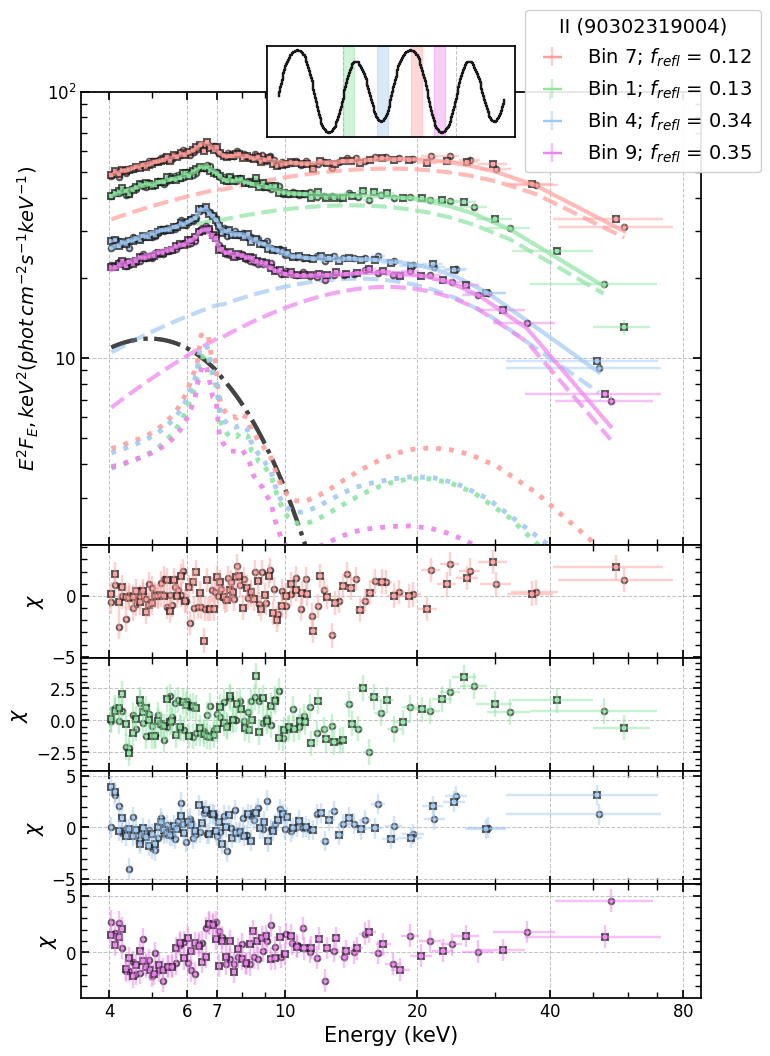

In [13]:
fig,ax = plot_relf_spe('90302319004', [7, 1, 4, 9],  min_sig=60)
fig.savefig(plot_path+ '/ph-res/spe_high1.pdf')

Obs 90302319006; bin 2; refl_factor = 0.15
Obs 90302319006; bin 2; refl_factor = 0.15
Obs 90302319006; bin 7; refl_factor = 0.21
Obs 90302319006; bin 7; refl_factor = 0.21
Obs 90302319006; bin 9; refl_factor = 0.43
Obs 90302319006; bin 9; refl_factor = 0.43
Obs 90302319006; bin 5; refl_factor = 0.48
Obs 90302319006; bin 5; refl_factor = 0.48


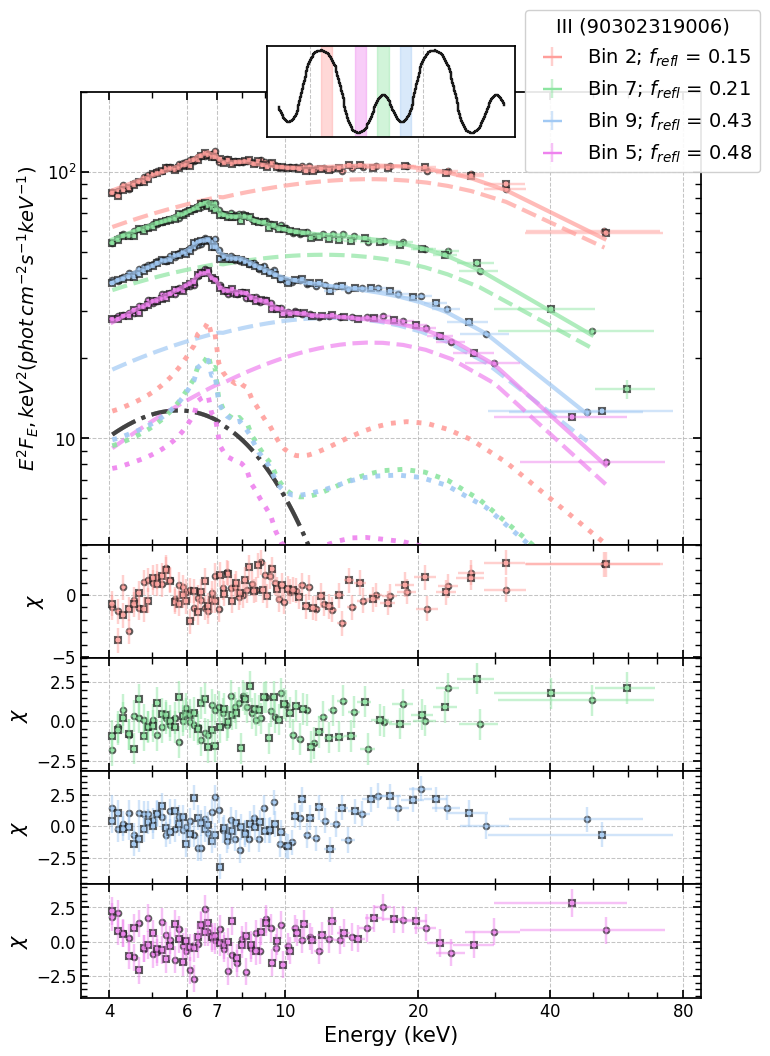

In [14]:
fig, ax = plot_relf_spe('90302319006', [2, 7, 9, 5], min_sig=60)
fig.savefig(plot_path+ '/ph-res/spe_high2.pdf')

Obs 90302319008; bin 8; refl_factor = 0.07
Obs 90302319008; bin 8; refl_factor = 0.07
Obs 90302319008; bin 4; refl_factor = 0.07
Obs 90302319008; bin 4; refl_factor = 0.07
Obs 90302319008; bin 5; refl_factor = 0.10
Obs 90302319008; bin 5; refl_factor = 0.10
Obs 90302319008; bin 1; refl_factor = 0.15
Obs 90302319008; bin 1; refl_factor = 0.15


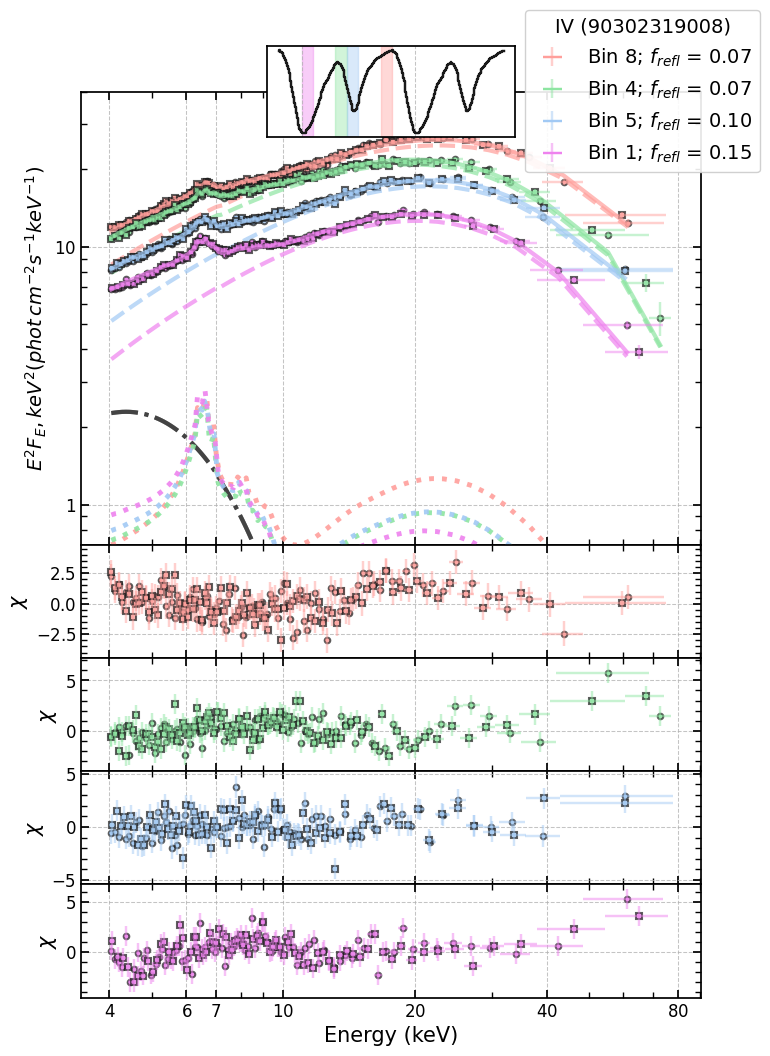

In [15]:
fig, ax = plot_relf_spe('90302319008',  [8, 4, 5, 1], min_sig=60)
fig.savefig(plot_path+ '/ph-res/spe_high3.pdf')

# Spectral plots for simultaneout fitting

In [5]:
def enumerate2(xs, start=0, step=1):
    for x in xs:
        yield (start, x)
        start += step

def plot_simult_spe(
    ObsID,
    bin_numbers,
    i_bins,
    min_sig = 75,
):
    ms, alpha, lw = 4, 0.7, 3


    fig = plt.figure(figsize=(10, 12))
    plotwidth = 4
    rows = len(bin_numbers)+plotwidth
    cols = 1
    ax = plt.subplot2grid((rows, cols), (0, 0), rowspan=plotwidth, colspan=1)
    ax_delchi = [plt.subplot2grid((rows, cols), (i, 0),
                                rowspan=1, colspan=1, sharex=ax) for i in range(plotwidth, rows)]
    plt.subplots_adjust(hspace=0)



    ax_pp = ax.inset_axes([0.3, 0.9, 0.4, 0.2])
    plot_pulse_profile(ObsID, ax_pp)
    ax_pp.tick_params(axis='both',which='both',labelbottom=False,bottom=False,top = False,left=False)
    ax_pp.set_yticks([])

    os.chdir(f"/sj0243/results/out{ObsID}/products/phase_resolved")
    xspec.AllData.clear()
    xspec.AllModels.clear()
    xspec.Xset.restore(f'/sj0243/results/out{ObsID}/products/phase_resolved/xspec/simult_4.xcm')

    #for i, bin_number in enumerate2(bin_numbers, step = 2):
    for ii_delchi, (i, bin_number) in enumerate(zip(i_bins, bin_numbers)):
        label = 'Bin '+str(bin_number)
        for gr, m, l in zip([i+1,i+2], ['o', 's'], [label, '_'+ label]):
            Plot.device = "/null"
            Plot.setRebin(min_sig, min_sig)
            Plot("eeufs")
            Plot.xAxis = "keV"
            en = np.array(Plot.x(gr))
            data = np.array(Plot.y(gr))
            en_err = np.array(Plot.xErr(gr))
            data_err = np.array(Plot.yErr(gr))
            model = np.array(Plot.model(gr))

            ax.loglog(en, data, marker = m, lw = 0, alpha = alpha, ms = ms)#, zorder = 10)   
            color =  ax.get_lines()[-1].get_color()         
            ax.loglog(en, model, ls = ':', alpha = alpha, color = color)#, zorder = 10)   
            ax.errorbar(en, data, data_err, en_err,
                            fmt='none', ecolor=color, alpha=alpha*0.7, label=l)#, zorder = 9)

            Plot("del")
            Plot.xAxis = "keV"
            en = np.array(Plot.x(gr))
            delchi = np.array(Plot.y(gr))
            en_err = np.array(Plot.xErr(gr))
            delchi_err = np.array(Plot.yErr(gr))

            ax_delchi[ii_delchi].semilogx(en, delchi, marker = m, lw = 0, alpha = alpha, ms = ms, color = color)
            ax_delchi[ii_delchi].errorbar(en, delchi, delchi_err, en_err,
                            fmt='none', ecolor=color, alpha=alpha*0.7, label=l)#, zorder = 9)
            ax_delchi[ii_delchi].set_ylabel("$\chi$")

            #if gr//2==0:
            b = bin_number
            ax_pp.axvspan((b-1)/10, b/10, color = color, alpha = 0.4)





        ax.set_xscale("log")
        ax_delchi[-1].set_xlabel("Energy (keV)")


        ax.set_ylabel('$E^2F_E, keV^2 (phot\, cm^{-2} s^{-1} keV^{-1})$', fontsize = 14)
        l = ax.legend(bbox_to_anchor=(0.7, 0.8), loc = 'lower left', title = ObsAlias[ObsID], fontsize = 14,  title_fontsize = 14, framealpha=0.9)
        for lh in l.legendHandles:
            lh.set_alpha(1)
        ax.set_xticks([4, 6, 7, 10, 20, 40, 80])
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


    xspec.Xset.restore(f'/sj0243/results/out{ObsID}/products/phase_resolved/xspec/simult_4.xcm_model')
    mo_loaded = xspec.AllModels(1)
    mo_loaded.bbodyrad.norm = '0 -1'
    #mo_loaded.relxilllp.norm = '0 -1'
    mo_loaded.cutoffpl.norm = '0 -1'
    Plot("eeufs")
    Plot.xAxis = "keV"
    en = np.array(Plot.x())
    data = np.array(Plot.model())
    ax.loglog(en, data, lw = lw, alpha = alpha, ls = ':', color = 'k')   


    xspec.Xset.restore(f'/sj0243/results/out{ObsID}/products/phase_resolved/xspec/simult_4.xcm_model')
    mo_loaded = xspec.AllModels(1)
    #mo_loaded.bbodyrad.norm = '0 -1'
    mo_loaded.relxilllp.norm = '0 -1'
    mo_loaded.cutoffpl.norm = '0 -1'
    Plot("eeufs")
    Plot.xAxis = "keV"
    en = np.array(Plot.x())
    data = np.array(Plot.model())
    ax.loglog(en, data, lw = lw, alpha = alpha, ls = '-.', color = 'k')   




    if ObsID=='90302319004':
        ax.set_ylim(2,100)
    if ObsID=='90302319006':
        ax.set_ylim(4,200)
    if ObsID=='90302319008':
        ax.set_ylim(0.7,40)


    return ax








***Warning: The file sent to Xset.restore(): /sj0243/results/out90302319004/products/phase_resolved/xspec/simult_4.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.



***Warning: The file sent to Xset.restore(): /sj0243/results/out90302319004/products/phase_resolved/xspec/simult_4.xcm_model
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.



***Warning: The file sent to Xset.restore(): /sj0243/results/out90302319004/products/phase_resolved/xspec/simult_4.xcm_model
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.




<AxesSubplot:ylabel='$E^2F_E, keV^2 (phot\\, cm^{-2} s^{-1} keV^{-1})$'>

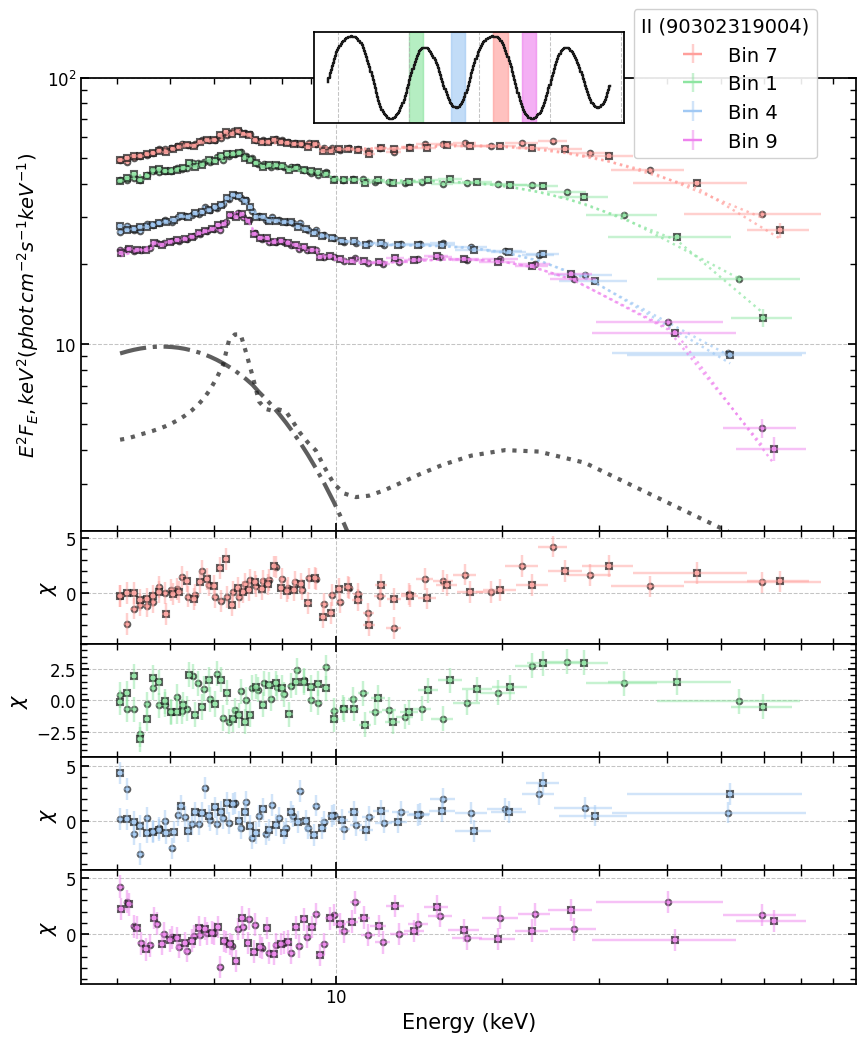

In [10]:
plot_simult_spe('90302319004', bin_numbers=[7, 1, 4, 9], i_bins = [2, 6, 0, 4])


***Warning: The file sent to Xset.restore(): /sj0243/results/out90302319006/products/phase_resolved/xspec/simult_4.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.



***Warning: The file sent to Xset.restore(): /sj0243/results/out90302319006/products/phase_resolved/xspec/simult_4.xcm_model
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.



***Warning: The file sent to Xset.restore(): /sj0243/results/out90302319006/products/phase_resolved/xspec/simult_4.xcm_model
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.




<AxesSubplot:ylabel='$E^2F_E, keV^2 (phot\\, cm^{-2} s^{-1} keV^{-1})$'>

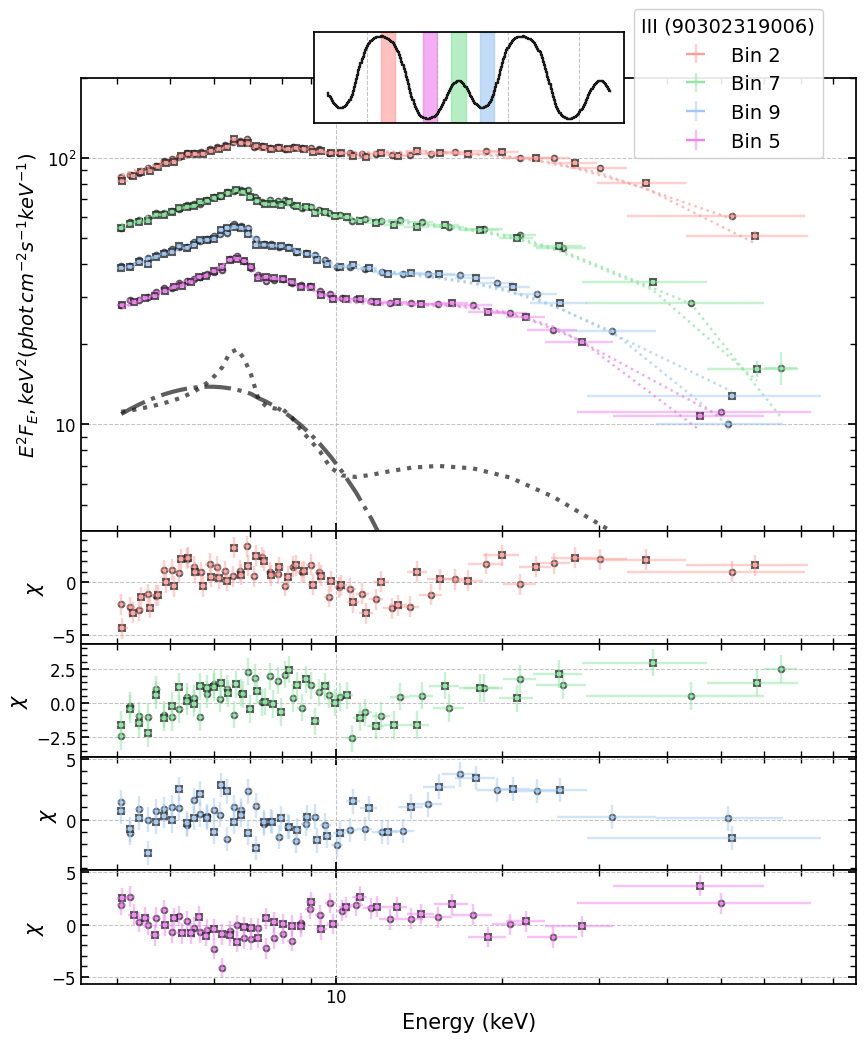

In [8]:
plot_simult_spe('90302319006', bin_numbers=[2,7,9,5], i_bins = [4, 6, 2, 0])

 *** loading RELXILL model (version 1.4.3) *** 

***Warning: The file sent to Xset.restore(): /sj0243/results/out90302319008/products/phase_resolved/xspec/simult_4.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.



***Warning: The file sent to Xset.restore(): /sj0243/results/out90302319008/products/phase_resolved/xspec/simult_4.xcm_model
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.



***Warning: The file sent to Xset.restore(): /sj0243/results/out90302319008/products/phase_resolved/xspec/simult_4.xcm_model
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.




<AxesSubplot:ylabel='$E^2F_E, keV^2 (phot\\, cm^{-2} s^{-1} keV^{-1})$'>

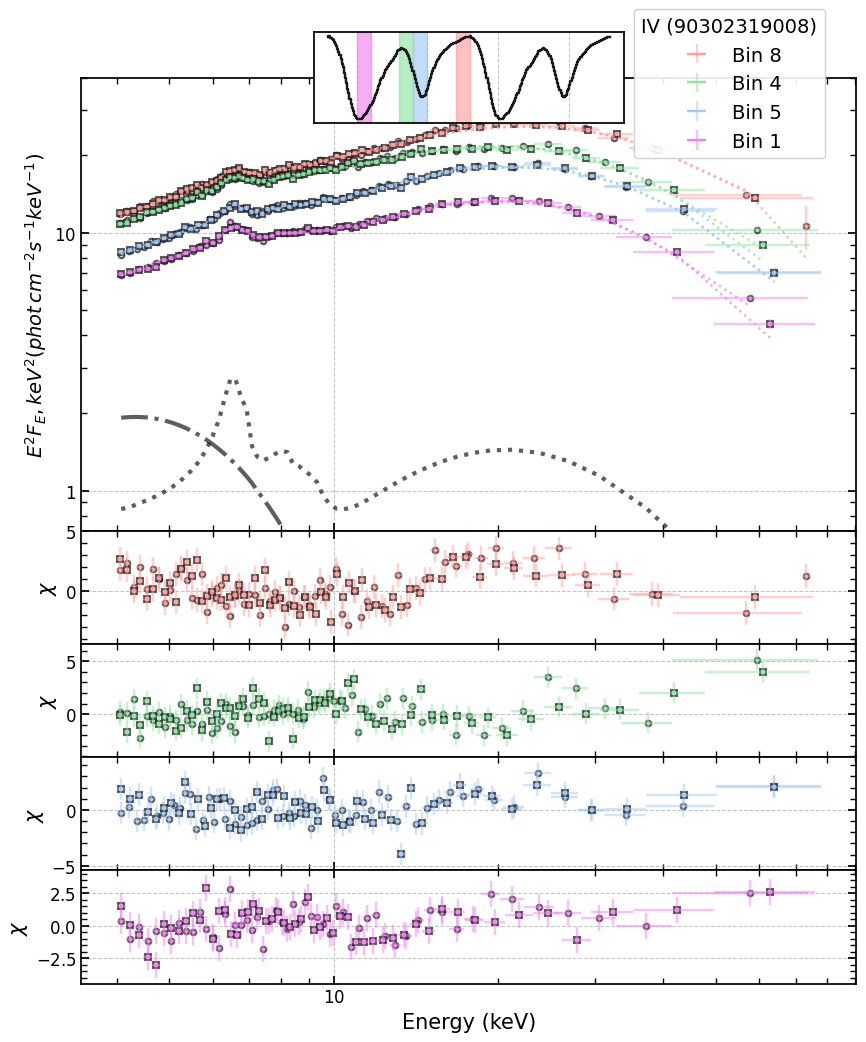

In [6]:
plot_simult_spe('90302319008', bin_numbers=[8,4,5,1], i_bins = [6, 2, 4, 0])

In [ ]:
#1.000 = 6733.163532/6734